# Neural Style Transfer

In [116]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms 
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import save_image
from torch.autograd import Variable

## Load Style and Content Images

In [119]:
# Load style and content images
style = Image.open("./images/marilyn_warhol.jpg")
content = Image.open("./images/duke.jpg")

device = torch.device("cuda" if torch.cuda.is_available else "cpu")

## Helper functions to convert between tensor and images

In [120]:
# Parameters
img_out_size = 512


def image_to_tensor(image, img_out_size):
    # Resize and convert to tensor
    # If the image is not img_out_size x img_out_size then CenterCrop it so it is
    resize_img = transforms.Compose(
        [
            transforms.Resize([img_out_size, img_out_size]),
            # transforms.CenterCrop(img_out_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    img_r = resize_img(image)

    # Add in batch dimension
    image = img_r.unsqueeze(0)
    return image.to(device)

In [121]:
style_t = image_to_tensor(style, img_out_size)
content_t = image_to_tensor(content, img_out_size)

# Check that we have RGB for both and that the height dimension == img_out_size
print(style_t.size(), content_t.size())

torch.Size([1, 3, 512, 512]) torch.Size([1, 3, 512, 512])


In [122]:
def tensor_to_image(image):
    # Get rid of batch dimension
    image = image.cpu().squeeze()

    # Switch around dimensions (C,H,W --> H,W,C)
    img_r = transforms.ToPILImage()
    image = img_r(image)
    return image

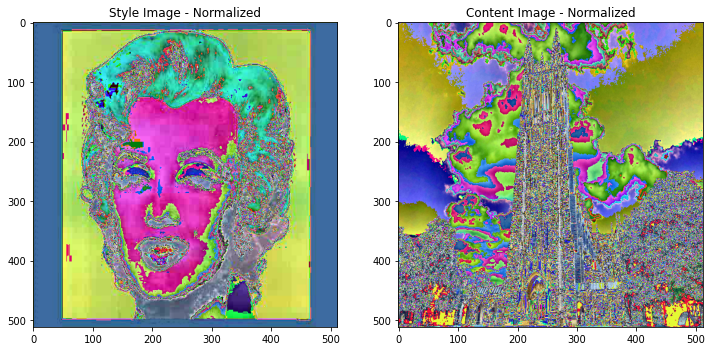

In [123]:
style_image_reshaped = tensor_to_image(style_t)
content_image_reshaped = tensor_to_image(content_t)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Style Image - Normalized")
plt.imshow(style_image_reshaped)

plt.subplot(1, 2, 2)
plt.title("Content Image - Normalized")
plt.imshow(content_image_reshaped)
plt.show()

# Style and Content Loss

In [124]:
def gramian_matrix(style_map):
    # Get dimensions of input from input
    b, c, h, w = style_map.size()

    # For each channel, flatten the values of the height and the weight
    # Take the dot product of this between itself and it's transpose to get the pixel coorelation (inner product)
    G_matrix = torch.bmm(
        style_map.view(b, c, h * w), (style_map.view(b, c, h * w).transpose(1, 2))
    )

    # Normalize values of gram matrix by diving by bchw
    return G_matrix.div(h * w)

In [125]:
loss = torch.nn.MSELoss()

def content_loss(gc, c):
    # Return the content loss (mse loss between generated image (gc) and original (g))
    return loss(gc, c)


def style_loss(gs, s):
    s = gramian_matrix(s)
    gs = gramian_matrix(gs)
    return loss(gs, s)

## VGG Pre-trained model (eval)

In [126]:
# Set device to CUDA
# Only use features as we don't need the linear layers and set device to eval mode since we are not training
vgg = models.vgg19(pretrained=True).features.to(device).eval()

#for param in vgg.parameters():
#    param.requires_grad = False

In [127]:
# Convert MaxPool2d layers to AveragePool2d for more aesthetically pleasing images as stated in the paper

for i in [4, 9, 18, 27, 36]:
    vgg[i] = nn.AvgPool2d(kernel_size=2, stride=2)

## Create Forward Hook to Extract Feature Maps

In [128]:
# Create forward hook to extract output of conv layer
# Guidance from https://www.kaggle.com/sironghuang/understanding-pytorch-hooks
class Hook():
    features = None
    def __init__(self, module,):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.output = output
    def close(self):
        self.hook.remove()

## Hyperparameters

In [129]:
# Number of iterations
iters = 30

# Output file name
filename = 'duke_marilyn'

# start reconstruction with original content image
# Requires grad so pixel values are optimized to reduce loss

# Content Init
original_cont = content_t.clone().requires_grad_(True).to(device)

# Style Init
#original_cont = style_t.clone().requires_grad_(True).to(device)

#Random Noise
#original_cont = Variable(torch.randn(original_cont.size()).type_as(original_cont.data), requires_grad=True)


# Set Style and Content layers
# original 
style_hooks = [0, 5, 10, 19, 28]
content_hook = [21]
# +1 layer style hooks
#style_hooks = [2, 7, 12, 21, 30]


# Set Style Weights
style_weights = [1e3/n**2 for n in [64,128,256,512,512]]
#style_weights = [0,0,0,.2,.2]
#style_weights = [1e3/n**2 for n in [512,512,256,128,64]]

# Set Alpha and Beta 
alpha = 1
beta = 1e4
optimizer = optim.LBFGS([original_cont])

## Run Model

In [130]:
# Save them hooks
hooked = []
for i, layer in enumerate(vgg.children()):
    hooked.append(Hook(vgg[i]))

for i in range(iters):
    def closure():
        # zero gradients
        optimizer.zero_grad()

        # init loss
        content_l = 0
        style_l = 0

        ############## Original Image ##############
        # put image through the network
        vgg(original_cont)

        # Get list feature maps for each layer
        fmaps2 = [layer.output for layer in hooked] 

        # get 
        input_fmaps = fmaps2[content_hook[0]]

        style_c_fmaps = [
            fmaps2[style_hooks[0]],
            fmaps2[style_hooks[1]],
            fmaps2[style_hooks[2]],
            fmaps2[style_hooks[3]],
            fmaps2[style_hooks[4]]]

        ############## Style image #################
        # Theoretically shouldn't be putting style image and content image in /
        # loop but does not work if i don't?

        vgg(style_t)

        # Get list feature maps for each layer
        fmaps = [layer.output for layer in hooked] 

        style_fmaps = [
            fmaps[style_hooks[0]],
            fmaps[style_hooks[1]],
            fmaps[style_hooks[2]],
            fmaps[style_hooks[3]],
            fmaps[style_hooks[4]]]

        ############## Content Image ###############

        vgg(content_t)

        # Get list feature maps for each layer
        fmaps3 = [layer.output for layer in hooked] 

        # get 
        content_fmaps = fmaps3[content_hook[0]]

        ############## Loss ########################

        # Get loss for style
        #style_l = style_loss(style_c_fmaps[0], style_fmaps[0])
        style_l = [style_loss(i,n) for i,n in zip(style_c_fmaps, style_fmaps)]

        # Style loss weighting
        style_l = [a*b for a,b in zip(style_l,style_weights)]
        style_l = sum(style_l)

        # Get loss for content
        content_l = content_loss(content_fmaps, input_fmaps)
        total_loss = (alpha * content_l) + (beta * style_l)

        #backpropagate
        total_loss.backward()

        #if i % 6 == 0:
            #print(f'Epoch: {i}\nStyle Loss: {style_l}\nContent Loss: {content_l}\nTotal Loss: {total_loss}\n')

            #save_image(original_cont, f"{filename}{str(i)}.jpg", normalize = True)
            
        return total_loss

    optimizer.step(closure)
save_image(original_cont, f'{filename}.jpg', normalize = True)

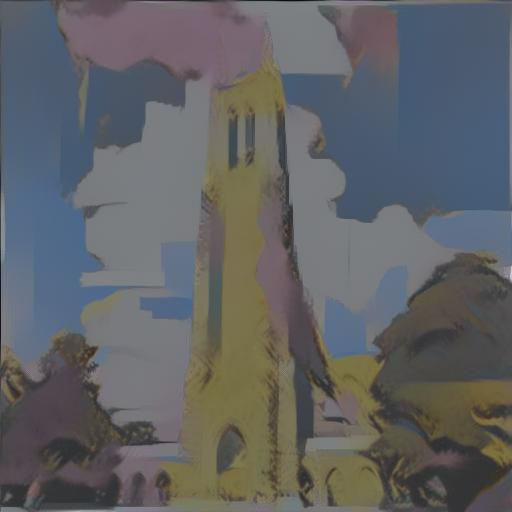

In [131]:
Image.open(f'{filename}.jpg')

## Using Adam

In [ ]:
un

In [ ]:
iters = 6000

# start reconstruction with original content image
original_cont = content_t.clone().requires_grad_(True).to(device)

optimizer = optim.Adam([original_cont])

style_hooks = [0, 5, 10, 19, 28]
content_hook = [21]

style_weights = [1e3/n**2 for n in [64,128,256,512,512]]1 an

alpha = 1
beta = 1e4

# Save them hooks
hooked = []
for i, layer in enumerate(vgg.children()):
    hooked.append(Hook(vgg[i]))

    

for i in range(iters):
        
    # zero gradients
    optimizer.zero_grad()
    
    # init loss
    content_l = 0
    style_l = 0
    
    ########## Original Image ##########
    # put image through the network
    vgg(original_cont)
    
    # Get list feature maps for each layer
    fmaps2 = [layer.output for layer in hooked] 

    # get 
    input_fmaps = fmaps2[content_hook[0]]

    style_c_fmaps = [
        fmaps2[style_hooks[0]],
        fmaps2[style_hooks[1]],
        fmaps2[style_hooks[2]],
        fmaps2[style_hooks[3]],
        fmaps2[style_hooks[4]]]
    
    ########## Style image ##########
    
    vgg(style_t)

    # Get list feature maps for each layer
    fmaps = [layer.output for layer in hooked] 

    style_fmaps = [
        fmaps[style_hooks[0]],
        fmaps[style_hooks[1]],
        fmaps[style_hooks[2]],
        fmaps[style_hooks[3]],
        fmaps[style_hooks[4]]]

    ########## Content Image ##########

    vgg(content_t)

    # Get list feature maps for each layer
    fmaps3 = [layer.output for layer in hooked] 

    # get 
    content_fmaps = fmaps3[content_hook[0]]
    
    ########## Loss ##########

    # Get loss for style
    #style_l = style_loss(style_c_fmaps[0], style_fmaps[0])
    style_l = [style_loss(i,n) for i,n in zip(style_c_fmaps, style_fmaps)]

    # Style loss weighting
    style_l = [a*b for a,b in zip(style_l,style_weights)]
    style_l = sum(style_l)
    
    # Get loss for content
    content_l = content_loss(content_fmaps, input_fmaps)
    total_loss = (alpha * content_l) + (beta * style_l)
    
    #backpropagate
    total_loss.backward()

    if i % 500 == 0:
        print(f'Epoch: {i}\nStyle Loss: {style_l}\nContent Loss: {content_l}\nTotal Loss: {total_loss}\n')
    
    optimizer.step()

In [ ]:
save_image(original_cont, 'star_night_50.jpg')

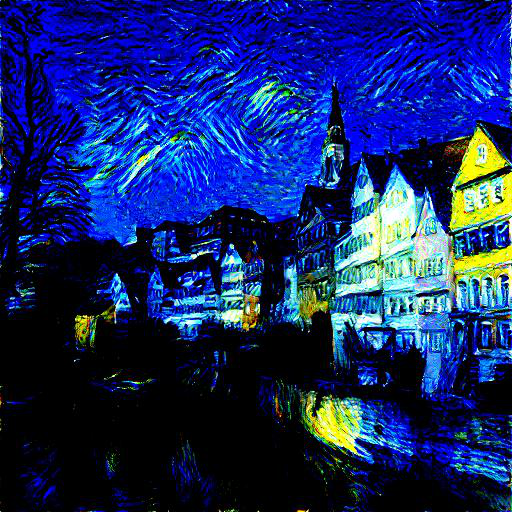

In [ ]:
Image.open('star_night_50.jpg')